In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import seaborn as sns
import pandas as pd
import os

# fit_out and intensities folders
fit_outs_folder = './data/fit_outs/'
intensities_folder = './data/Idts/'

### Load fit parameters and scan infos

In [23]:
### LOAD FIT OUT ###

# get file names

fit_out_files = os.listdir(fit_outs_folder)
fit_out_files.sort()
fit_out_files = [f for f in fit_out_files if f.startswith('fit_out_')]

# load fit parameters
fit_outs = {}
for f in fit_out_files:
    fit_outs[f[8:-4]] = pd.read_csv(fit_outs_folder + f)
    fit_outs[f[8:-4]]['scan'] = f[8:-4]


# generate dataframe
fit_outs_df = pd.DataFrame()
for i in fit_outs.keys():
    fit_outs_df = pd.concat([fit_outs_df,fit_outs[i]])
fit_outs_df = fit_outs_df.set_index('scan') # make scan the index
fit_outs = fit_outs_df
del fit_outs_df


### LOAD SCAN_INFO.CSV ###
scan_info = pd.read_csv('./data/scan_info.csv')
scan_info = scan_info.set_index('scan')


### ADD INFORMATIONS TO FIT OUT ###
# make a dictionary of scan_info
scan_info_dict = {}
for i in scan_info.index:
    scan_info_dict[i] = {}
    for j in scan_info.columns:
        scan_info_dict[i][j] = scan_info[j][i]
# add information to fit_outs dataframe
fit_outs['ID_sample'] = [scan_info_dict[i]['ID_sample'] for i in fit_outs.index]
fit_outs['T'] = [scan_info_dict[i]['T'] for i in fit_outs.index]
fit_outs['d'] = [scan_info_dict[i]['d'] for i in fit_outs.index]
fit_outs['E'] = [scan_info_dict[i]['E'] for i in fit_outs.index]
fit_outs['Q'] = [scan_info_dict[i]['Q'] for i in fit_outs.index]
fit_outs['Note'] = [scan_info_dict[i]['Note'] for i in fit_outs.index]

display(scan_info.head())
display(fit_outs.head())

,ID_sample,T,d,E,Q,Note
scan,,,,,,
GeO2_6_0001_0007,6,30,100,9.7,0.19,test
GeO2_6_0001_0008,6,30,100,9.7,0.19,test
GeO2_6_0001_0009,6,30,100,9.7,0.19,test
GeO2_6_0001_0011,6,30,100,9.7,0.19,test
GeO2_6_0001_0012,6,30,100,9.7,0.19,NaN


,t,tau,beta,c,y0,dtau,dbeta,dc,dy0,ID_sample,T,d,E,Q,Note
scan,,,,,,,,,,,,,,,
GeO2_6_0001_0007,100.2,5.165474,0.717951,0.033048,1.002197,0.467173,0.044145,0.001717,0.000066,6,30,100,9.7,0.19,test
GeO2_6_0001_0008,600.2,5.335211,0.730145,0.032415,1.002180,0.194079,0.017878,0.000674,0.000010,6,30,100,9.7,0.19,test
GeO2_6_0001_0009,603.0,5.152362,0.724139,0.033397,1.002190,0.222818,0.021290,0.000807,0.000013,6,30,100,9.7,0.19,test
GeO2_6_0001_0011,37.7,2.440422,0.919343,0.031599,1.002039,0.582098,0.217981,0.005032,0.000276,6,30,100,9.7,0.19,test
GeO2_6_0001_0011,113.0,5.093858,0.911775,0.031195,1.001913,0.542395,0.099911,0.002259,0.000205,6,30,100,9.7,0.19,test


## Dose rate definition

In [24]:
A = {8.67: np.pi*7*5, 21.67: np.pi*5.2*4.4, 15.875: np.pi*7.1*3.7}

# density of GeO2
rho = 3.7 * 10**(-4*3) * 10**(-3) # kg/um^3

# Photon flux
phi = {8.67: 2.1e12, 21.67: 8.3e11, 15.875: 9.3e11}

# attenuation length
la = {8.67: 68, 21.67: 113, 15.875: 'x'}

dose_rate= lambda E, d: phi[E]*(1-np.exp(-d/la[E]))*(E*1.6022e-16)/(rho*A[E]*d)

### to be continued ........

# GeO2_6 Temperature dependence

## Dose analysis

In [25]:
#################################################
idx = scan_info[scan_info.ID_sample==6].index
#################################################

Ts = np.sort(scan_info.loc[idx]['T'].unique())

# da cambiare col nuovo formalismo
'''
# tau
fig, ax = plt.subplots(figsize=(10, 5))
for T in Ts:
    df_temp = fit_outs[scan_info.loc[idx]['T'] == T]
    ax.errorbar(df_temp.t, df_temp.tau, yerr=df_temp.dtau, fmt='o', label='T = '+str(T)+'C')
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel(r'$\tau$ [s]')
plt.legend()
plt.tight_layout(), plt.show();

# beta
fig, ax = plt.subplots(figsize=(10, 5))
for T in Ts:
    df_temp = df[df['T'] == T]
    ax.errorbar(df_temp.t, df_temp.beta, yerr=df_temp.dbeta, fmt='o', label='T = '+str(T)+'C')
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel(r'$\beta$')
plt.legend()
plt.tight_layout(), plt.show();

# c
fig, ax = plt.subplots(figsize=(10, 5))
for T in Ts:
    df_temp = df[df['T'] == T]
    ax.errorbar(df_temp.t, df_temp.c, yerr=df_temp.dc, fmt='o', label='T = '+str(T)+'C')
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel(r'$c$')
plt.legend()
plt.tight_layout(), plt.show();

# y0
fig, ax = plt.subplots(figsize=(10, 5))
for T in Ts:
    df_temp = df[df['T'] == T]
    ax.errorbar(df_temp.t, df_temp.y0, yerr=df_temp.dy0, fmt='o', label='T = '+str(T)+'C')
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel(r'$y_0$')
plt.legend()
plt.tight_layout(), plt.show();
'''

"\n# tau\nfig, ax = plt.subplots(figsize=(10, 5))\nfor T in Ts:\n    df_temp = fit_outs[scan_info.loc[idx]['T'] == T]\n    ax.errorbar(df_temp.t, df_temp.tau, yerr=df_temp.dtau, fmt='o', label='T = '+str(T)+'C')\nplt.xscale('log')\nplt.xlabel('t [s]')\nplt.ylabel(r'$\tau$ [s]')\nplt.legend()\nplt.tight_layout(), plt.show();\n\n# beta\nfig, ax = plt.subplots(figsize=(10, 5))\nfor T in Ts:\n    df_temp = df[df['T'] == T]\n    ax.errorbar(df_temp.t, df_temp.beta, yerr=df_temp.dbeta, fmt='o', label='T = '+str(T)+'C')\nplt.xscale('log')\nplt.xlabel('t [s]')\nplt.ylabel(r'$\x08eta$')\nplt.legend()\nplt.tight_layout(), plt.show();\n\n# c\nfig, ax = plt.subplots(figsize=(10, 5))\nfor T in Ts:\n    df_temp = df[df['T'] == T]\n    ax.errorbar(df_temp.t, df_temp.c, yerr=df_temp.dc, fmt='o', label='T = '+str(T)+'C')\nplt.xscale('log')\nplt.xlabel('t [s]')\nplt.ylabel(r'$c$')\nplt.legend()\nplt.tight_layout(), plt.show();\n\n# y0\nfig, ax = plt.subplots(figsize=(10, 5))\nfor T in Ts:\n    df_temp =

## Temperature dependence

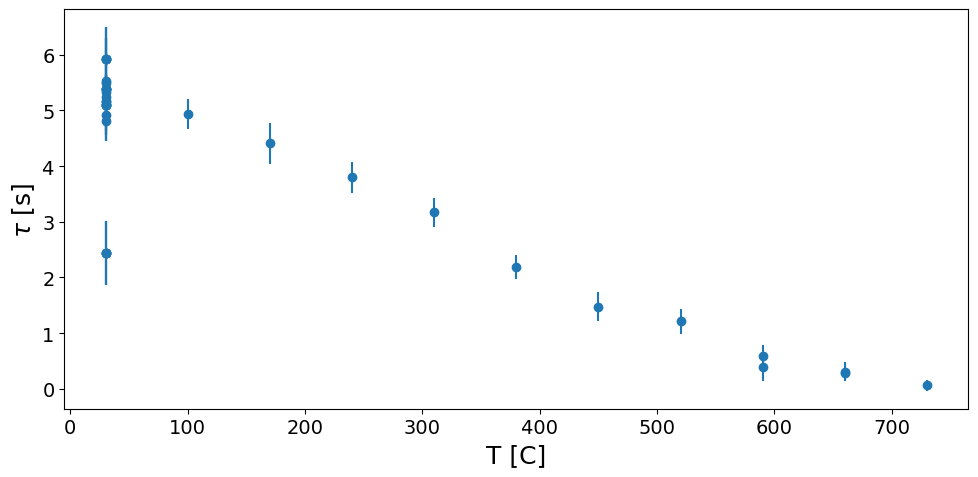

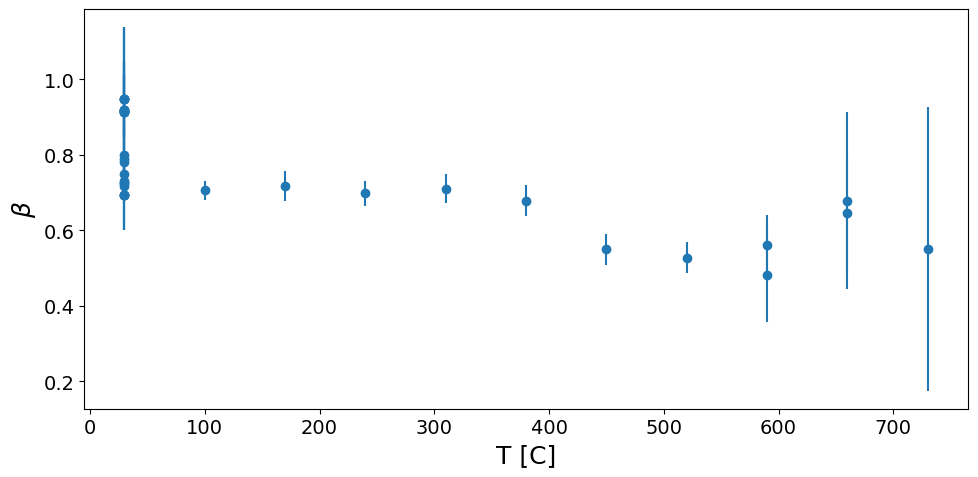

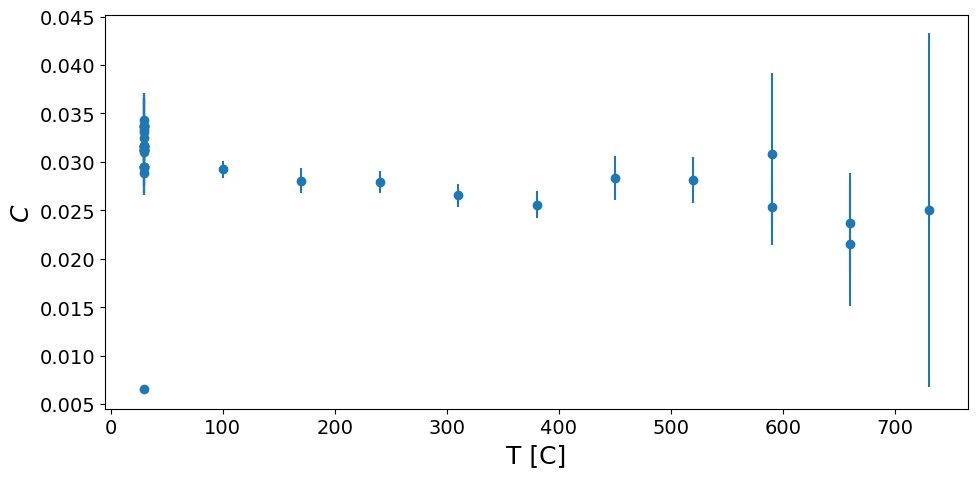

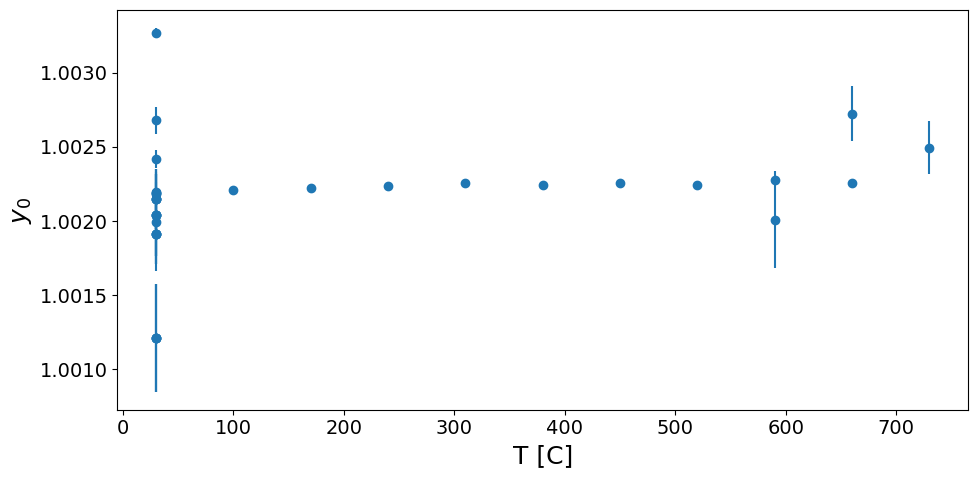

In [26]:
#################################################
idx = fit_outs[fit_outs.ID_sample==6].index
#################################################

fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(fit_outs.loc[idx]['T'], fit_outs.loc[idx]['tau'], yerr=fit_outs.loc[idx]['dtau'], fmt='o')
#ax.plot(Ts, np.zeros(len(Ts)), 'ro')
##plt.yscale('log')
plt.xlabel('T [C]')
plt.ylabel(r'$\tau$ [s]')
plt.tight_layout(), plt.show();

# beta
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(fit_outs.loc[idx]['T'], fit_outs.loc[idx]['beta'], yerr=fit_outs.loc[idx]['dbeta'], fmt='o')
#plt.xscale('log')
plt.xlabel('T [C]')
plt.ylabel(r'$\beta$')
plt.tight_layout(), plt.show();

# C
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(fit_outs.loc[idx]['T'], fit_outs.loc[idx]['c'], yerr=fit_outs.loc[idx]['dc'], fmt='o')
#plt.yscale('log')
plt.xlabel('T [C]')
plt.ylabel(r'$C$')
plt.tight_layout(), plt.show();

# y0
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(fit_outs.loc[idx]['T'], fit_outs.loc[idx]['y0'], yerr=fit_outs.loc[idx]['dy0'], fmt='o')
#plt.yscale('log')
plt.xlabel('T [C]')
plt.ylabel(r'$y_0$')
plt.tight_layout(), plt.show();


## Q analysis

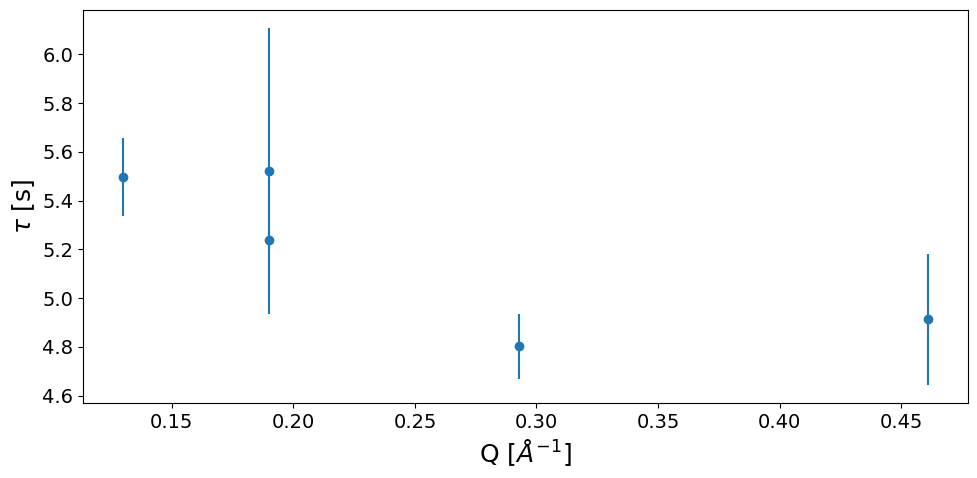

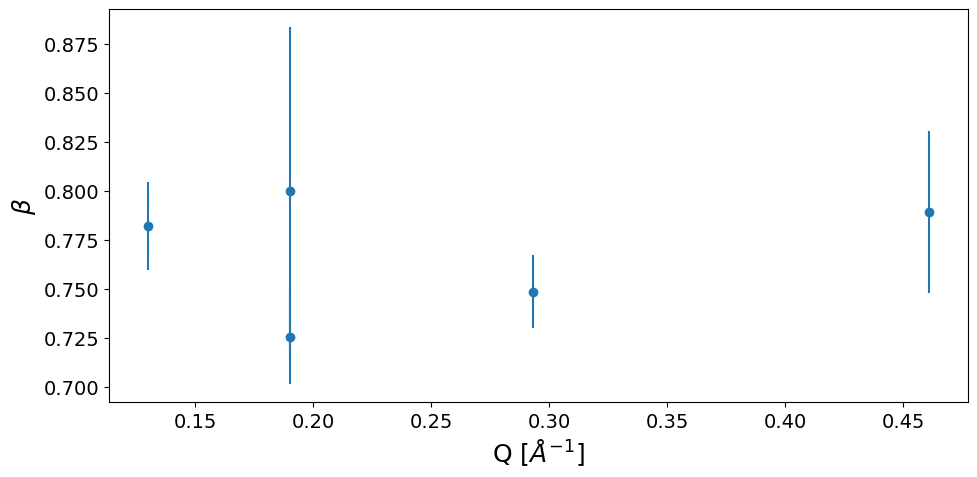

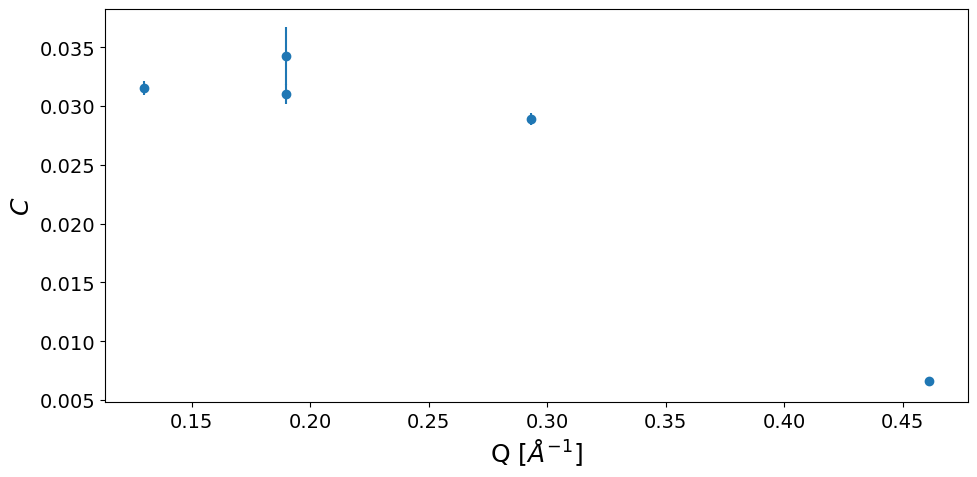

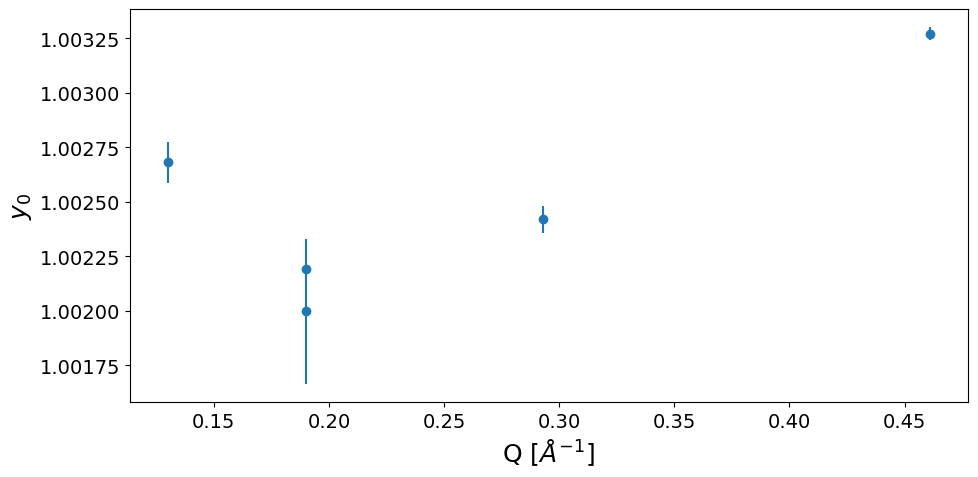

In [27]:
#################################################
idx = fit_outs[(fit_outs.ID_sample==6) & (fit_outs['T']==30) & (fit_outs['Note']!='test')].index
#################################################

# tau
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx]['Q'], fit_outs.loc[idx]['tau'], yerr=fit_outs.loc[idx]['dtau'], fmt='o')
##plt.yscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$\tau$ [s]')
plt.tight_layout(), plt.show();

# beta
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx]['Q'], fit_outs.loc[idx]['beta'], yerr=fit_outs.loc[idx]['dbeta'], fmt='o')
#plt.xscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$\beta$')
plt.tight_layout(), plt.show();

# C
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx]['Q'], fit_outs.loc[idx]['c'], yerr=fit_outs.loc[idx]['dc'], fmt='o')
#plt.yscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$C$')
plt.tight_layout(), plt.show();

# y0
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx]['Q'], fit_outs.loc[idx]['y0'], yerr=fit_outs.loc[idx]['dy0'], fmt='o')
#plt.yscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$y_0$')
plt.tight_layout(), plt.show();



# GeO2_6 Temperature dependence

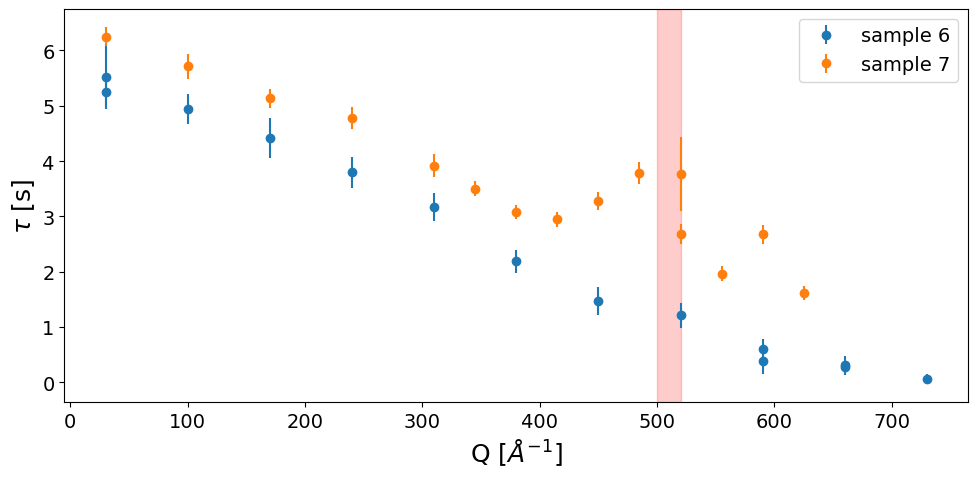

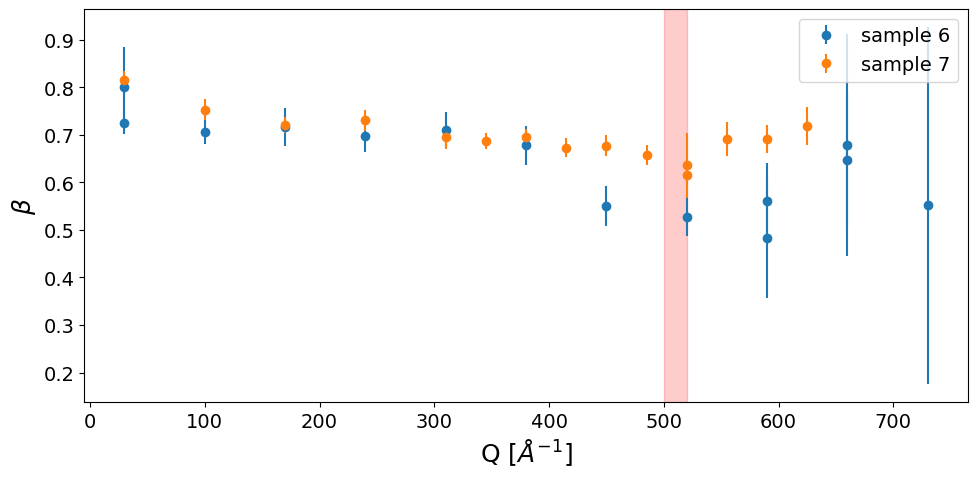

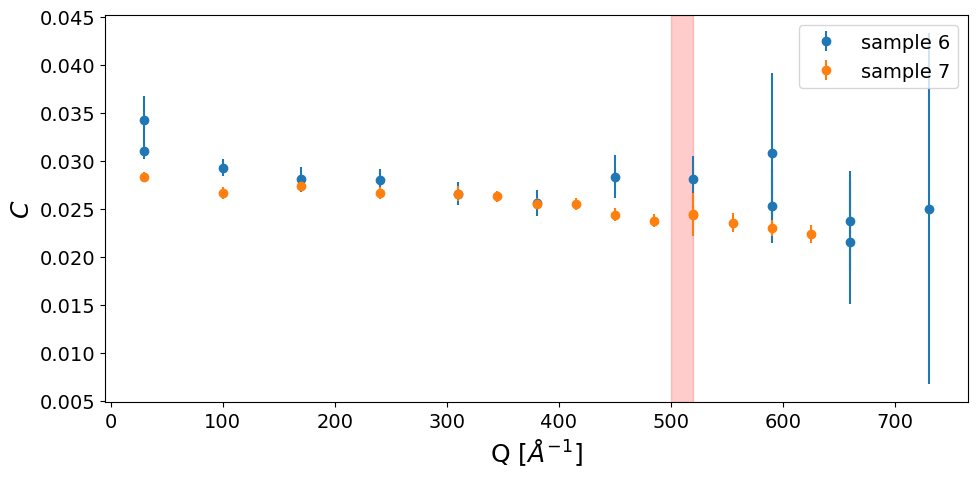

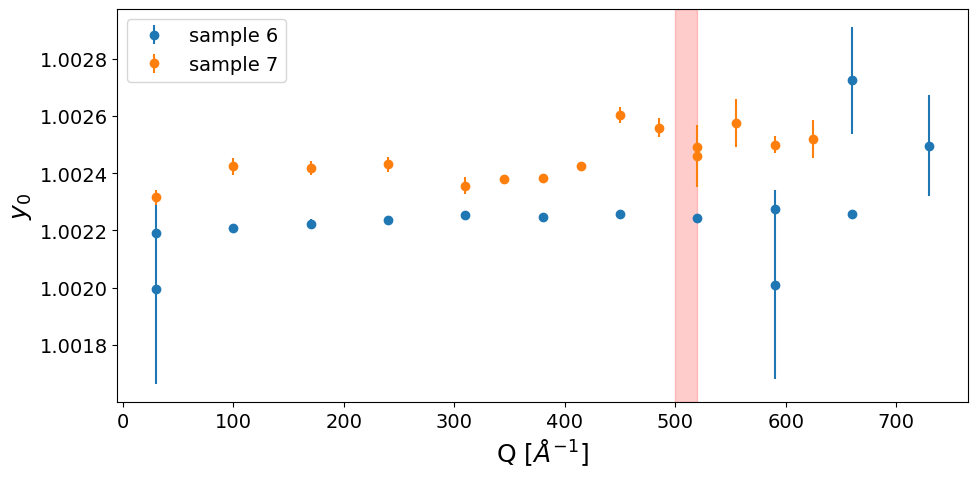

In [28]:
#################################################
idx_6 = fit_outs[(fit_outs.ID_sample==6) & (fit_outs['Q']==.19) & (fit_outs['Note']!='test')].index
idx_7 = fit_outs[(fit_outs.ID_sample==7) & (fit_outs['Q']==.19) & (fit_outs['Note']!='test')].index
#################################################

# tau
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx_6]['T'], fit_outs.loc[idx_6]['tau'], yerr=fit_outs.loc[idx_6]['dtau'], fmt='o', label='sample 6')
ax.errorbar(fit_outs.loc[idx_7]['T'], fit_outs.loc[idx_7]['tau'], yerr=fit_outs.loc[idx_7]['dtau'], fmt='o', label='sample 7')
plt.axvspan(500, 520, alpha=0.2, color='red')
##plt.yscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$\tau$ [s]')
plt.legend()
plt.tight_layout(), plt.show();

# beta
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx_6]['T'], fit_outs.loc[idx_6]['beta'], yerr=fit_outs.loc[idx_6]['dbeta'], fmt='o', label='sample 6')
ax.errorbar(fit_outs.loc[idx_7]['T'], fit_outs.loc[idx_7]['beta'], yerr=fit_outs.loc[idx_7]['dbeta'], fmt='o', label='sample 7')
plt.axvspan(500, 520, alpha=0.2, color='red')
#plt.xscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$\beta$')
plt.legend()
plt.tight_layout(), plt.show();

# C
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx_6]['T'], fit_outs.loc[idx_6]['c'], yerr=fit_outs.loc[idx_6]['dc'], fmt='o', label='sample 6')
ax.errorbar(fit_outs.loc[idx_7]['T'], fit_outs.loc[idx_7]['c'], yerr=fit_outs.loc[idx_7]['dc'], fmt='o', label='sample 7')
plt.axvspan(500, 520, alpha=0.2, color='red')
#plt.yscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$C$')
plt.legend()
plt.tight_layout(), plt.show();

# y0
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(fit_outs.loc[idx_6]['T'], fit_outs.loc[idx_6]['y0'], yerr=fit_outs.loc[idx_6]['dy0'], fmt='o', label='sample 6')
ax.errorbar(fit_outs.loc[idx_7]['T'], fit_outs.loc[idx_7]['y0'], yerr=fit_outs.loc[idx_7]['dy0'], fmt='o', label='sample 7')
plt.axvspan(500, 520, alpha=0.2, color='red')
#plt.yscale('log')
plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel(r'$y_0$')
plt.legend()
plt.tight_layout(), plt.show();
